In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import random
from torch.utils.data import Subset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torch.nn import functional as F
import pandas as pd
import scipy

seed = 999

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

dataset_name = 'cifar10'

In [2]:
a = np.array([1, 2, 3])
b = np.array([1, 2, 3])
a = torch.tensor(a, dtype=torch.float32)
b = torch.tensor(b, dtype=torch.float32)
a_norm = torch.norm(a, p=2)
b_norm = torch.norm(b, p=1)
print(a_norm)
print(b_norm)

tensor(3.7417)
tensor(6.)


In [3]:
1+4+9

14

In [29]:
def generate_federated_datasets(dataset, num_clients, alpha, num_samples_per_client):
    """
    Generate federated datasets using Dirichlet distribution.
    
    :param dataset: PyTorch dataset (e.g., MNIST)
    :param num_clients: Number of clients
    :param alpha: Concentration parameter for Dirichlet distribution
    :param num_samples_per_client: List of number of samples per client
    :return: List of DataLoaders for each client
    """
    assert len(num_samples_per_client) == num_clients, "Length of num_samples_per_client must match num_clients"
    
    num_classes = len(np.unique(dataset.targets))
    
    # Generate Dirichlet distribution for label distributions for each client
    label_distributions = np.random.dirichlet([alpha] * num_clients, num_classes)
    
    # Get indices of each class in the dataset
    class_indices = [np.where(np.array(dataset.targets) == i)[0] for i in range(num_classes)]
    
    # Allocate instances to each client based on the generated label distributions
    client_indices = [[] for _ in range(num_clients)]
    for c in range(num_classes):
        np.random.shuffle(class_indices[c])
        proportions = np.cumsum(label_distributions[c])
        proportions = np.insert(proportions, 0, 0)
        class_splits = [int(p * len(class_indices[c])) for p in proportions]
        
        for i in range(num_clients):
            client_indices[i].extend(class_indices[c][class_splits[i]:class_splits[i+1]])
    
    # Create DataLoader for each client
    client_loaders = []
    client_datasets = []
    for i, indices in enumerate(client_indices):
        if num_samples_per_client[i] < len(indices):
            indices = np.random.choice(indices, num_samples_per_client[i], replace=False)
        client_dataset = Subset(dataset, indices)
        client_loaders.append(DataLoader(client_dataset, batch_size=32, shuffle=True))
        client_datasets.append(client_dataset)
    
    return client_datasets, client_loaders


if(dataset_name == 'mnist'):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    dataset = datasets.MNIST(root='../../data', train=True, download=True, transform=transform)
if(dataset_name == 'cifar10'):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset = datasets.CIFAR10(root='../../data', train=True, download=True, transform=transform)



Files already downloaded and verified


In [ ]:
#function to split cifar10 into datasets of only one class
def split_cifar10(dataset):
    num_classes = 10
    class_datasets = []
    for i in range(num_classes):
        class_datasets.append(Subset(dataset, np.where(np.array(dataset.targets) == i)[0]))
    return class_datasets

In [ ]:
num_clients = 10
alpha = 0.5
#n_samples_per_client = [1000, 200, 300, 900, 1100]
#n_samples_per_client = np.random.uniform(0,1,num_clients)
# Generate Dirichlet distribution for data size distributions for each client
n_samples_per_client = np.random.dirichlet([alpha] * num_clients, 1)[0]
n_samples_per_client = np.round(n_samples_per_client/np.sum(n_samples_per_client)*len(dataset))
n_samples_per_client = n_samples_per_client.astype(int)
client_datasets, client_loaders = generate_federated_datasets(dataset, num_clients, alpha, n_samples_per_client)

# Access each client's DataLoader
for i, loader in enumerate(client_loaders):
    print(f"Client {i+1} has {len(loader.dataset)} samples")

In [5]:
#plot a heatmap: X-axis is client number, Y-axis is label number, and the value in each cell is the number of samples in that client with that label.
def plot_label_distributions(client_loaders):
    num_clients = len(client_loaders)
    num_classes = len(np.unique(client_loaders[0].dataset.dataset.targets))
    label_counts = np.zeros((num_clients, num_classes))
    
    for i, loader in enumerate(client_loaders):
        for _, labels in loader:
            for c in labels:
                label_counts[i][c] += 1
    
    #plt.figure(figsize=(5, 8))
    sns.heatmap(label_counts.T, annot=True, fmt=".1f", cmap="Blues", cbar=False)
    plt.xlabel("Client ID")
    plt.ylabel("Label")
    plt.title("Label distributions for each client")
    plt.show()

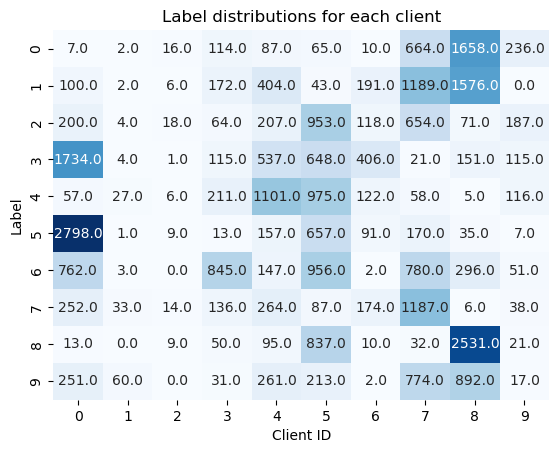

In [6]:
plot_label_distributions(client_loaders)

In [7]:
class FederatedClient():
    def __init__(self, model, criterion, train_loader, device, val_loader=None):
        self.model = model
        #self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        
    def train(self, num_epochs, learning_rate, weight_decay, fed_alg, mu=0):
        optimizer = optim.SGD(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.model.to(self.device)
        self.model.train()
        global_model = copy.deepcopy(self.model)
        train_loss = []
        train_acc = []
        for epoch in range(num_epochs):
            epoch_loss = 0
            epoch_acc = 0
            loss1_sum = 0
            loss2_sum = 0
            for i, (x, y) in enumerate(self.train_loader):
                x = x.to(self.device)
                y = y.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(x)
                if(fed_alg=='fedavg'):
                    loss = self.criterion(outputs, y)
                elif(fed_alg=='fedprox'):
                    proximal_term = 0.0
                    for param, global_param in zip(self.model.parameters(), global_model.parameters()):
                        proximal_term += torch.norm(param - global_param, p=2)
                    loss1 = self.criterion(outputs, y) 
                    loss2 = mu/2 * proximal_term
                    loss = loss1 + loss2
                loss.backward()

                # Clip gradients
                #torch.nn.utils.clip_grad_norm_(self.model.parameters(), clip_value)

                optimizer.step()
                epoch_loss += loss.item()
                epoch_acc += (outputs.argmax(1) == y).sum().item()

            train_loss.append(epoch_loss / len(self.train_loader))
            train_acc.append(epoch_acc / len(self.train_loader.dataset))
        
        return self.model, train_loss, train_acc
    
    def test(self,test_loader):
        self.model.to(self.device)
        self.model.eval()
        test_loss = 0
        test_acc = 0
        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(self.device)
                y = y.to(self.device)
                outputs = self.model(x)
                loss = self.criterion(outputs, y)
                test_loss += loss.item()
                test_acc += (outputs.argmax(1) == y).sum().item()
        
        return test_loss / len(test_loader), test_acc / len(test_loader.dataset)
    
    def get_model(self):
        return self.model

def FedAvg(w,alpha):
    #alpha = alpha/np.sum(alpha) #normalize alpha
    w_avg = copy.deepcopy(w[0])
    n_clients = len(w)
    
    for l in w_avg.keys():
        w_avg[l] = w_avg[l] - w_avg[l]

    for l, layer in enumerate(w_avg.keys()): #for each layer
        w_kl = []
        for k in range(0,n_clients): #for each client
            w_avg[layer] += alpha[k]*w[k][layer]
    return w_avg
def softmax(x,tau):
    #x is a vector, tau is the temperature. large tau -> uniform distribution, small tau -> argmax
    return torch.exp(x/tau)/torch.sum(torch.exp(x/tau),dim=0)

def alpha_loss(alpha, target_labels=[], source_labels=[], dataset_sizes =[], reg_lambda=0):
    obj = np.linalg.norm(target_labels - np.matmul(source_labels,alpha),ord=2)**2 + reg_lambda * np.linalg.norm(alpha,ord=2)**2/np.linalg.norm(dataset_sizes,ord=1)
    return obj

def optimize_alpha(target_labels, source_labels, alpha, dataset_sizes, reg_lambda):
    #given a vector T(y) (target labels) and S(y) (source labels), optimize alpha with SGD
    #initialize alpha
    dataset_sizes = torch.tensor(dataset_sizes)
    #alpha = torch.tensor(alpha, requires_grad=True)
    #optimizer = optim.SGD([alpha], lr=eta)
    #for i in range(n_epochs):
        #soft_alpha = softmax(alpha, 0.1)
        #loss = torch.norm(target_labels - torch.matmul(source_labels,alpha),p=2)
        #loss2 = mu * torch.norm(alpha/dataset_sizes,p=2)
        #loss = loss1 + loss2
        #optimizer.zero_grad()
        #loss.backward()

        # Gradient clipping
        #torch.nn.utils.clip_grad_norm_([alpha], 0.5)

        #optimizer.step()
        
        #print(alpha.detach().numpy(), loss.item())
    constraints = scipy.optimize.LinearConstraint(np.ones(len(alpha)), lb=1, ub=1)
    bounds = scipy.optimize.Bounds(0,1)
    alpha = scipy.optimize.minimize(alpha_loss, alpha, args=(target_labels,source_labels, dataset_sizes, reg_lambda), constraints=constraints, bounds=bounds)
    return alpha

def train_fed(n_communication, num_local_epochs, clients_fed, lr, test_loader, wd=0.0, optimize_alpha_bool=False, target_labels=None, source_labels=None, reg_lambda=0):
    n_clients = len(clients_fed)
    mean_loss_fed = []
    mean_acc_fed = []
    test_acc_fed = []
    dataset_sizes = [clients_fed[i].train_loader.dataset.__len__() for i in range(n_clients)]
    if(not optimize_alpha_bool):
        alpha = np.array(dataset_sizes)/np.sum(dataset_sizes)
        print(alpha)
    for k in range(n_communication):
        train_losses_fed = []
        train_accs_fed = []
        param = []
        for i in range(n_clients-1):
            client_model, train_loss_fed, train_acc_fed = clients_fed[i].train(num_local_epochs,lr,wd,'fedavg')
            param.append(copy.deepcopy(client_model.state_dict()))
            train_losses_fed.append(train_loss_fed[-1])
            train_accs_fed.append(train_acc_fed[-1])

        mean_loss_fed.append(np.mean(train_losses_fed))
        mean_acc_fed.append(np.mean(train_accs_fed))
        print(f'Round {k} - mean loss: {mean_loss_fed[-1]}, mean acc: {mean_acc_fed[-1]}')

        if(optimize_alpha_bool):
            print(f'Round {k}')
            #initialize alpha
            alpha = np.random.rand(n_clients)
            alpha = alpha/np.sum(alpha)
            alpha = optimize_alpha(target_labels, source_labels, alpha, dataset_sizes, reg_lambda)
            alpha = alpha.x
            #alpha = alpha.detach().numpy()
            #assert np.sum(alpha) == 1, "Alpha must sum to 1"
            print(alpha)
        w_global_model_fedavg = FedAvg(param, alpha)
        for i in range(n_clients):
            clients_fed[i].model.load_state_dict(copy.deepcopy(w_global_model_fedavg))

        test_loss, test_acc = clients_fed[0].test(test_loader)
        test_acc_fed.append(test_acc)

    return clients_fed[0].model, mean_loss_fed, mean_acc_fed, test_acc_fed


In [8]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

class MLP_MNIST(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP_MNIST, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
def split_data(dataset,n_parts):
    #split dataset into equal parts uniformly
    dataset_length = len(dataset)
    splits = np.array_split(np.arange(dataset_length), n_parts)
    dataset_sizes = [len(split) for split in splits]
    client_datasets = torch.utils.data.random_split(dataset, lengths=dataset_sizes)
    return client_datasets

def get_label_distribution(dataset,n_labels):
    #get the distribution of labels in a dataset and return a vector with the fraction of samples for each label
    labels = []
    for data in dataset:
        labels.append(data[1])
    labels = np.array(labels)
    label_distribution = np.zeros(n_labels)
    for i in range(n_labels):
        label_distribution[i] = np.sum(labels==i)
    label_distribution = label_distribution/np.sum(label_distribution)
    return label_distribution

In [10]:
source_label_list = [get_label_distribution(client_datasets[i],n_labels=10) for i in range (len(client_datasets))]

In [11]:
source_labels = np.array([])
for s in source_label_list:
    #create matrix of all source label distributions:
    source_labels = np.append(source_labels,s)
source_labels = source_labels.reshape(len(client_datasets),10).T
print(source_labels)
#source_labels = torch.tensor(source_labels)


[[0.00113379 0.01470588 0.20253165 0.06510565 0.02668712 0.01196172
  0.00888099 0.12009405 0.22960809 0.29949239]
 [0.01619695 0.01470588 0.07594937 0.09822958 0.12392638 0.00791314
  0.169627   0.21504793 0.21825232 0.        ]
 [0.03239391 0.02941176 0.2278481  0.03655054 0.06349693 0.17537725
  0.10479574 0.1182854  0.00983243 0.23730964]
 [0.2808552  0.02941176 0.01265823 0.06567676 0.16472393 0.11924917
  0.36056838 0.00379816 0.02091123 0.14593909]
 [0.00923226 0.19852941 0.07594937 0.12050257 0.33773006 0.17942584
  0.10834813 0.01049014 0.00069242 0.14720812]
 [0.4531908  0.00735294 0.11392405 0.00742433 0.04815951 0.12090541
  0.08081705 0.03074697 0.00484697 0.00888325]
 [0.1234208  0.02205882 0.         0.48258138 0.04509202 0.17592933
  0.0017762  0.14107434 0.04099155 0.06472081]
 [0.04081633 0.24264706 0.17721519 0.0776699  0.0809816  0.01601031
  0.15452931 0.2146862  0.00083091 0.04822335]
 [0.0021056  0.         0.11392405 0.02855511 0.0291411  0.15403018
  0.00888099

In [12]:
np.sum(source_labels[:,-1])

1.0

In [13]:
source_labels[:,0:-1]

array([[0.00113379, 0.01470588, 0.20253165, 0.06510565, 0.02668712,
        0.01196172, 0.00888099, 0.12009405, 0.22960809],
       [0.01619695, 0.01470588, 0.07594937, 0.09822958, 0.12392638,
        0.00791314, 0.169627  , 0.21504793, 0.21825232],
       [0.03239391, 0.02941176, 0.2278481 , 0.03655054, 0.06349693,
        0.17537725, 0.10479574, 0.1182854 , 0.00983243],
       [0.2808552 , 0.02941176, 0.01265823, 0.06567676, 0.16472393,
        0.11924917, 0.36056838, 0.00379816, 0.02091123],
       [0.00923226, 0.19852941, 0.07594937, 0.12050257, 0.33773006,
        0.17942584, 0.10834813, 0.01049014, 0.00069242],
       [0.4531908 , 0.00735294, 0.11392405, 0.00742433, 0.04815951,
        0.12090541, 0.08081705, 0.03074697, 0.00484697],
       [0.1234208 , 0.02205882, 0.        , 0.48258138, 0.04509202,
        0.17592933, 0.0017762 , 0.14107434, 0.04099155],
       [0.04081633, 0.24264706, 0.17721519, 0.0776699 , 0.0809816 ,
        0.01601031, 0.15452931, 0.2146862 , 0.00083091],


In [14]:
#origin_model = MLP_MNIST(784, 64, 10)
origin_model = CNN()
print(origin_model)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [15]:
n_communication = 50
num_local_epochs = 1

model_fed = copy.deepcopy(origin_model)
criterion = nn.CrossEntropyLoss()
n_clients = len(client_loaders)
print('Number of clients: ', n_clients)
val_loader = None
lr = 0.1
wd = 0.0
device = 'cuda:0'

Number of clients:  10


In [16]:
clients_fed = []
for i in range(n_clients-1):
    clients_fed.append(FederatedClient(copy.deepcopy(origin_model), criterion, client_loaders[i], device, val_loader))

print(len(clients_fed))

model_fedavg, train_loss_fedavg, train_acc_fedavg, test_acc_fedavg = train_fed(n_communication, num_local_epochs, clients_fed, lr, test_loader=client_loaders[-1], wd=0.0, optimize_alpha_bool=False, target_labels=None, source_labels=None)

9
[0.20104201 0.00442852 0.00257245 0.05701726 0.10615435 0.17694562
 0.03666558 0.18003908 0.23513514]
Round 0 - mean loss: 1.9593984978780232, mean acc: 0.3111369352385731
Round 1 - mean loss: 1.8503651266457712, mean acc: 0.32982311774249323
Round 2 - mean loss: 1.7642111007732768, mean acc: 0.375716485845897
Round 3 - mean loss: 1.6894262214590445, mean acc: 0.39906149520425
Round 4 - mean loss: 1.6717637373078968, mean acc: 0.4145834791051917
Round 5 - mean loss: 1.615497641399077, mean acc: 0.4532593973137195
Round 6 - mean loss: 1.5851088273252678, mean acc: 0.4478025162895072
Round 7 - mean loss: 1.57723801653045, mean acc: 0.46432677023181634
Round 8 - mean loss: 1.5476231166148147, mean acc: 0.4623257917653776
Round 9 - mean loss: 1.5394911101150777, mean acc: 0.461799001919745
Round 10 - mean loss: 1.5107729352316288, mean acc: 0.47454960657236656
Round 11 - mean loss: 1.4926791256677752, mean acc: 0.4847066154147517
Round 12 - mean loss: 1.4900621131950507, mean acc: 0.4878

In [17]:
reg_alpha_list = [0.0,0.1,1.0,10.0,100.0]
train_loss_list_fedalpha = []
train_acc_list_fedalpha = []
test_acc_list_fedalpha = []
for reg_alpha in reg_alpha_list:
    clients_fed = []
    for i in range(n_clients-1):
        clients_fed.append(FederatedClient(copy.deepcopy(origin_model), criterion, client_loaders[i], device, val_loader))
    print(len(clients_fed))
    model_fedalpha, train_loss_fedalpha, train_acc_fedalpha, test_acc_fedalpha = train_fed(n_communication, num_local_epochs, clients_fed, lr, test_loader=client_loaders[-1], wd=0.0, optimize_alpha_bool=True, target_labels=source_labels[:,-1], source_labels=source_labels[:,0:-1], reg_lambda=reg_alpha)
    train_loss_list_fedalpha.append(train_loss_fedalpha)
    train_acc_list_fedalpha.append(train_acc_fedalpha)
    test_acc_list_fedalpha.append(test_acc_fedalpha)

9
Round 0 - mean loss: 1.9599478663908383, mean acc: 0.312435954328555
Round 0
[1.48103103e-18 3.88086939e-18 6.86070818e-01 8.82379898e-02
 1.64840894e-01 3.73162443e-02 2.35340543e-02 1.96568677e-17
 0.00000000e+00]
Round 1 - mean loss: 1.9052723895238683, mean acc: 0.3152659478167904
Round 1
[0.00000000e+00 3.68840613e-17 6.84790156e-01 8.84107826e-02
 1.66721154e-01 3.75966316e-02 2.24812758e-02 0.00000000e+00
 0.00000000e+00]
Round 2 - mean loss: 1.8492831007105075, mean acc: 0.3305155731945435
Round 2
[2.08083205e-17 3.24414751e-17 6.85876530e-01 8.82789086e-02
 1.65847636e-01 3.71501010e-02 2.28468247e-02 0.00000000e+00
 6.85850596e-18]
Round 3 - mean loss: 1.7844919983600573, mean acc: 0.3559248282137907
Round 3
[0.00000000e+00 0.00000000e+00 6.86392803e-01 8.81723981e-02
 1.65129668e-01 3.73394958e-02 2.29656348e-02 9.36057060e-18
 2.40897154e-17]
Round 4 - mean loss: 1.73950423826853, mean acc: 0.37797587004040434
Round 4
[3.57563614e-18 0.00000000e+00 6.85597785e-01 8.914566

In [25]:
reg_alpha = 10000
clients_fed = []
for i in range(n_clients-1):
    clients_fed.append(FederatedClient(copy.deepcopy(origin_model), criterion, client_loaders[i], device, val_loader))
print(len(clients_fed))
model_fedalpha, train_loss_fedalpha, train_acc_fedalpha, test_acc_fedalpha = train_fed(n_communication, num_local_epochs, clients_fed, lr, test_loader=client_loaders[-1], wd=0.0, optimize_alpha_bool=True, target_labels=source_labels[:,-1], source_labels=source_labels[:,0:-1], reg_lambda=reg_alpha)
train_loss_list_fedalpha.append(train_loss_fedalpha)
train_acc_list_fedalpha.append(train_acc_fedalpha)
test_acc_list_fedalpha.append(test_acc_fedalpha)

9
Round 0 - mean loss: 1.9606746316861763, mean acc: 0.3133778220627387
Round 0
[0.04108262 0.04874764 0.23555323 0.09138441 0.12559184 0.1404056
 0.11807577 0.09087772 0.10828117]
Round 1 - mean loss: 1.8633880364971573, mean acc: 0.3295540164426207
Round 1
[0.04101978 0.0487524  0.235629   0.0913635  0.12564687 0.14048858
 0.11798537 0.09098832 0.10812619]
Round 2 - mean loss: 1.7647985345316406, mean acc: 0.37281490047446414
Round 2
[0.04107038 0.0488012  0.23564063 0.0914455  0.12557092 0.14032974
 0.11811423 0.09082504 0.10820234]
Round 3 - mean loss: 1.7042389018464066, mean acc: 0.3958822172694848
Round 3
[0.04064549 0.04918755 0.23621371 0.09151602 0.12532233 0.14075076
 0.11802665 0.09040862 0.10792887]
Round 4 - mean loss: 1.670885231033223, mean acc: 0.4192683829571391
Round 4
[0.04121875 0.04869137 0.23558089 0.09131745 0.12576614 0.14051819
 0.11798209 0.09085311 0.10807202]
Round 5 - mean loss: 1.5660638176493258, mean acc: 0.4511899151205535
Round 5
[0.04114959 0.0487892

In [18]:
np.sum(np.array([ 0.000e+00 ,0.000e+00 , 6.859e-01 , 8.821e-02,  1.648e-01,3.752e-02 , 2.362e-02 , 7.999e-18,  1.805e-17]))

1.0000499999999999

In [16]:
np.sum(np.array([ 0.08551682, -0.1886856 ,  0.47567357 , 0.30127594 ,-0.22296916 , 0.12180724, 0.18096235 , 0.17005322  ,0.18622196]))

1.1098563399999999

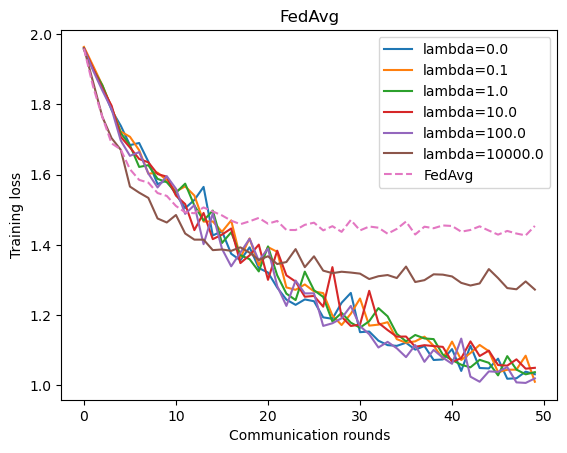

In [28]:
for i in range(len(reg_alpha_list)+1):
    plt.plot(train_loss_list_fedalpha[i])
#plt.plot(train_loss_fedalpha)
plt.plot(train_loss_fedavg,'--')
plt.xlabel('Communication rounds')
plt.ylabel('Training loss')
plt.title('FedAvg')
plt.legend(['lambda=0.0','lambda=0.1','lambda=1.0','lambda=10.0','lambda=100.0','lambda=10000.0','FedAvg'])

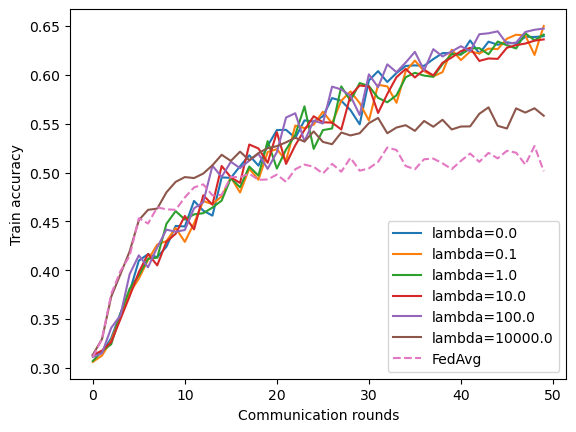

In [29]:
for i in range(len(reg_alpha_list)+1):
    plt.plot(train_acc_list_fedalpha[i])

plt.plot(train_acc_fedavg,'--')
plt.xlabel('Communication rounds')
plt.ylabel('Train accuracy')
plt.legend(['lambda=0.0','lambda=0.1','lambda=1.0','lambda=10.0','lambda=100.0','lambda=10000.0','FedAvg'])

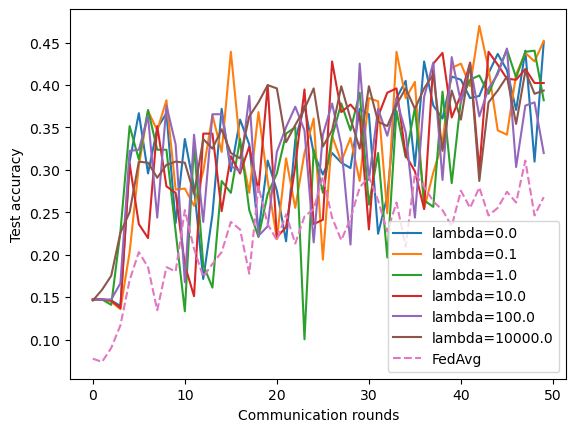

In [30]:
for i in range(len(reg_alpha_list)+1):
    plt.plot(test_acc_list_fedalpha[i])
plt.plot(test_acc_fedavg,'--')
plt.xlabel('Communication rounds')
plt.ylabel('Test accuracy')
plt.legend(['lambda=0.0','lambda=0.1','lambda=1.0','lambda=10.0','lambda=100.0','lambda=10000.0','FedAvg'])

In [24]:
#all combinations of number 0-9
import itertools
combinations = list(itertools.combinations(np.arange(10),2))
combinations

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (6, 7),
 (6, 8),
 (6, 9),
 (7, 8),
 (7, 9),
 (8, 9)]

In [38]:
#df = pd.read_csv('/home/edvinli/Documents/Git/FedDG_Benchmark-1/fed_alpha_experiments/save/mnist/results', sep=';')
df = pd.read_csv('/home/edvinli/Documents/Git/FedDG_Benchmark-1/fed_alpha_experiments/save/cifar10/results_cifar', sep=';')
df = df[(df.seed == 568) | (df.seed == 569) | (df.seed == 570)]
df

,n_rounds,num_clients,local_ep,bs,lr,lr_alpha,reg_lambda,seed,dirichlet_beta,dataset,val_acc_fed,val_acc_fedalpha,test_acc_fedavg,test_acc_fedalpha
15,100,10,1,32,0.1,0.1,10,570,0.5,cifar10,NaN,0.3924,NaN,0.537769
16,100,10,1,32,0.1,0.1,10,568,0.5,cifar10,NaN,0.4425,NaN,0.414847
17,100,10,1,32,0.1,0.1,10,569,0.5,cifar10,NaN,0.4791,NaN,0.578089
18,100,10,1,32,0.1,0.1,100,570,0.5,cifar10,NaN,0.3965,NaN,0.549025
19,100,10,1,32,0.1,0.1,100,568,0.5,cifar10,NaN,0.4466,NaN,0.427948
20,100,10,1,32,0.1,0.1,100,569,0.5,cifar10,NaN,0.4882,NaN,0.575758
21,100,10,1,32,0.1,0.1,1000,570,0.5,cifar10,NaN,0.4398,NaN,0.588294
22,100,10,1,32,0.1,0.1,1000,568,0.5,cifar10,NaN,0.4565,NaN,0.461426
23,100,10,1,32,0.1,0.1,1000,569,0.5,cifar10,NaN,0.4838,NaN,0.575758
24,100,10,1,32,0.1,0.1,10000,570,0.5,cifar10,NaN,0.4035,NaN,0.546023


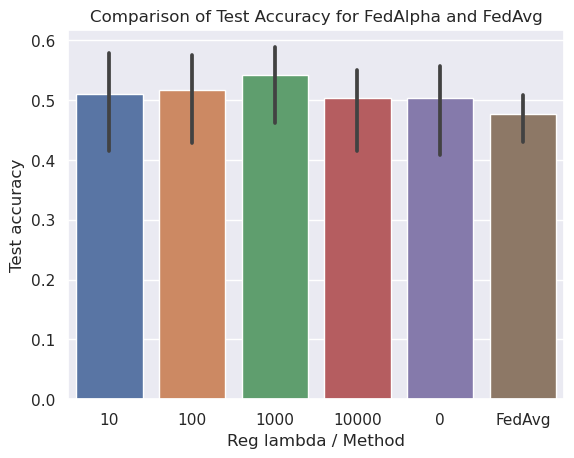

In [46]:
# Assuming df is your dataframe
# First, we will create a new DataFrame for test_acc_fedavg with a constant reg_lambda label
# drop nans
df_fedavg = df[['test_acc_fedavg']].dropna().copy()
df_fedavg['reg_lambda'] = 'FedAvg'  # Assign a label for the x-axis
df_fedavg['test_acc_fedalpha'] = df_fedavg['test_acc_fedavg']  # Align column name with fedalpha for plotting
df_fedavg = df_fedavg[['reg_lambda', 'test_acc_fedalpha']]

# Now, concatenate the original dataframe with the new df_fedavg
df_combined = pd.concat([df[['reg_lambda', 'test_acc_fedalpha']], df_fedavg])

# Plot the combined dataframe
sns.set_theme()
sns.set_style("darkgrid")

sns.barplot(data=df_combined, x='reg_lambda', y='test_acc_fedalpha')

plt.xlabel('Reg lambda / Method')
plt.ylabel('Test accuracy')
plt.title('Comparison of Test Accuracy for FedAlpha and FedAvg')
plt.show()

In [48]:
df_combined

,reg_lambda,test_acc_fedalpha
15,10,0.537769
16,10,0.414847
17,10,0.578089
18,100,0.549025
19,100,0.427948
20,100,0.575758
21,1000,0.588294
22,1000,0.461426
23,1000,0.575758
24,10000,0.546023


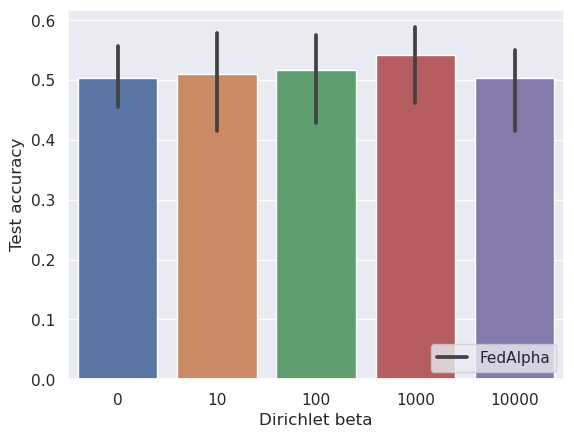

In [37]:
sns.set_theme()
sns.set_style("darkgrid")
sns.barplot(data=df, x='reg_lambda', y='test_acc_fedalpha')
plt.xlabel('Dirichlet beta')
plt.ylabel('Test accuracy')
#legend in bottom right
#x log axis
#plt.xscale('log')

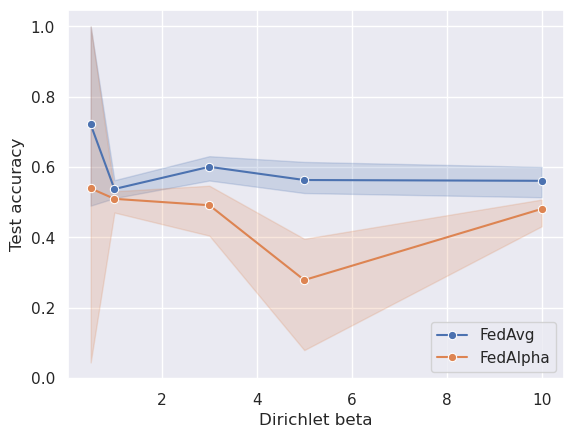

In [15]:
sns.set_theme()
sns.set_style("darkgrid")
sns.lineplot(data=df, x='dirichlet_beta', y='test_acc_fedavg',marker='o')
sns.lineplot(data=df, x='dirichlet_beta', y='test_acc_fedalpha',marker='o')
plt.xlabel('Dirichlet beta')
plt.ylabel('Test accuracy')
#legend in bottom right
plt.legend(['FedAvg', 'FedAlpha'], loc='lower right')
#x log axis
#plt.xscale('log')

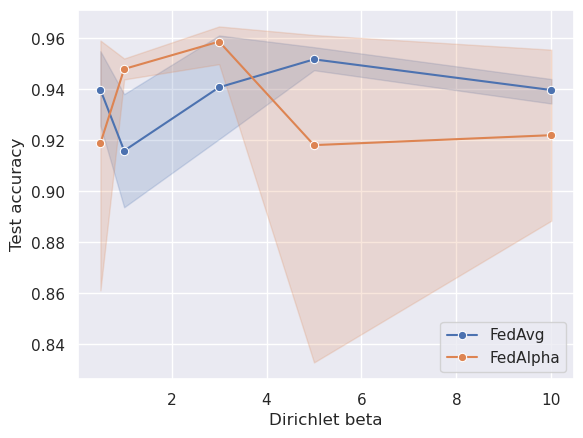

In [6]:
sns.set_theme()
sns.set_style("darkgrid")
sns.lineplot(data=df, x='dirichlet_beta', y='test_acc_fedavg',marker='o')
sns.lineplot(data=df, x='dirichlet_beta', y='test_acc_fedalpha',marker='o')
plt.xlabel('Dirichlet beta')
plt.ylabel('Test accuracy')
#legend in bottom right
plt.legend(['FedAvg', 'FedAlpha'], loc='lower right')

In [8]:
df = pd.read_csv('/home/edvinli/Documents/Git/FedDG_Benchmark-1/fed_alpha_experiments/save/mnist/results_hparam', sep=';')
df

,n_rounds,num_clients,local_ep,bs,lr,lr_alpha,seed,dirichlet_beta,method,dataset,val_acc_fedavg,val_acc_fedalpha,val_loss_fedavg,val_loss_fedalpha
0,100,10,1,32,0.100,0.100,1427,0.5,fedalpha,mnist,NaN,0.937167,NaN,0.229972
1,100,10,1,32,0.100,0.010,4008,0.5,fedalpha,mnist,NaN,0.868250,NaN,0.557680
2,100,10,1,32,0.100,0.001,4869,0.5,fedalpha,mnist,NaN,0.887583,NaN,0.422705
3,100,10,1,32,0.010,0.100,3698,0.5,fedalpha,mnist,NaN,0.340167,NaN,2.070383
4,100,10,1,32,0.010,0.010,8033,0.5,fedalpha,mnist,NaN,0.825500,NaN,0.732152
5,100,10,1,32,0.010,0.001,2048,0.5,fedalpha,mnist,NaN,0.735917,NaN,1.309647
6,100,10,1,32,0.001,0.100,185,0.5,fedalpha,mnist,NaN,0.211000,NaN,2.717188
7,100,10,1,32,0.001,0.010,3179,0.5,fedalpha,mnist,NaN,0.102167,NaN,2.287172
8,100,10,1,32,0.001,0.001,382,0.5,fedalpha,mnist,NaN,0.264583,NaN,2.218888
9,100,10,1,32,0.100,0.100,8912,0.5,fedavg,mnist,0.935083,NaN,0.237320,NaN


In [9]:
df_fed = df[df['method']=='fedavg']
df_fed

,n_rounds,num_clients,local_ep,bs,lr,lr_alpha,seed,dirichlet_beta,method,dataset,val_acc_fedavg,val_acc_fedalpha,val_loss_fedavg,val_loss_fedalpha
9,100,10,1,32,0.100,0.1,8912,0.5,fedavg,mnist,0.935083,NaN,0.237320,NaN
10,100,10,1,32,0.010,0.1,331,0.5,fedavg,mnist,0.910333,NaN,0.318176,NaN
11,100,10,1,32,0.001,0.1,8857,0.5,fedavg,mnist,0.315667,NaN,2.168232,NaN


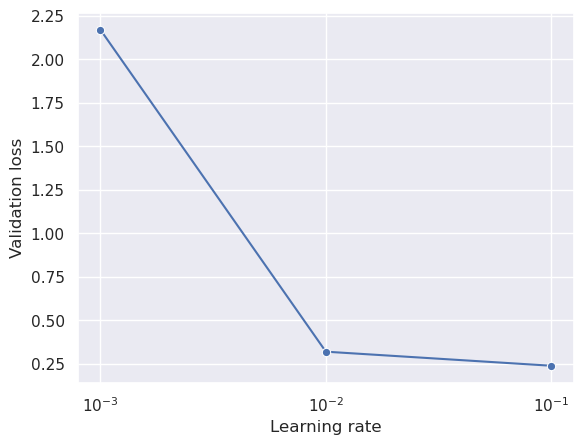

In [10]:
#plot lr vs val_loss_fedavg for fed_fed
sns.set_theme()
sns.set_style("darkgrid")
sns.lineplot(data=df_fed, x='lr', y='val_loss_fedavg',marker='o')
plt.xlabel('Learning rate')
plt.ylabel('Validation loss')
#logscale x-axis
plt.xscale('log')

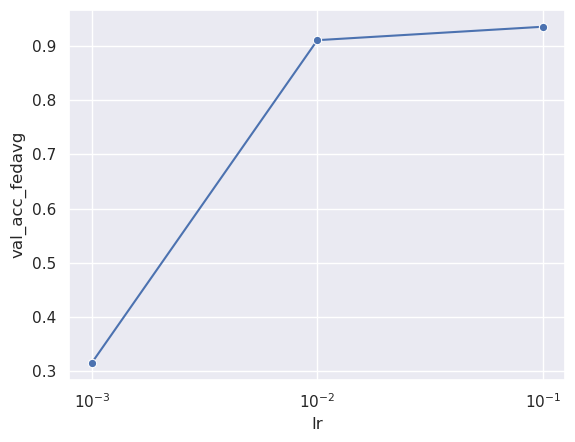

In [11]:
df_fed = df[df['method']=='fedavg']
sns.lineplot(data=df_fed, x='lr', y='val_acc_fedavg',marker='o')
#xlog scale
plt.xscale('log')

<AxesSubplot:xlabel='lr_alpha', ylabel='lr'>

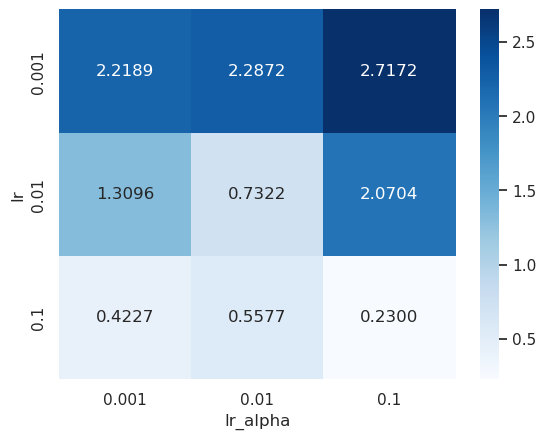

In [12]:
#plot heatmap of val_loss_fedalpha, with lr on x-axis and lr_alpha on y-axis
#drop rows in val_loss_fedalpha with NaN values
df_pivot = df.dropna(subset=['val_loss_fedalpha'])
df_pivot = df_pivot[['lr','lr_alpha','val_loss_fedalpha']].pivot('lr','lr_alpha','val_loss_fedalpha')
sns.heatmap(df_pivot, annot=True, fmt=".4f", cmap="Blues", cbar=True)

<AxesSubplot:xlabel='lr_alpha', ylabel='lr'>

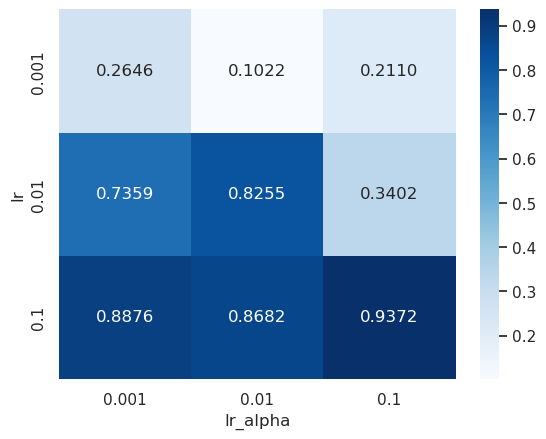

In [13]:
#plot heatmap of val_loss_fedalpha, with lr on x-axis and lr_alpha on y-axis
df_pivot = df.dropna(subset=['val_acc_fedalpha'])
df_pivot = df_pivot[['lr','lr_alpha','val_acc_fedalpha']].pivot('lr','lr_alpha','val_acc_fedalpha')
sns.heatmap(df_pivot, annot=True, fmt=".4f", cmap="Blues", cbar=True)